In [57]:
import tensorflow as tf

# Disabilita la GPU prima di qualsiasi altra operazione
tf.config.experimental.set_visible_devices([], 'GPU')

# Verifica che la GPU sia stata disabilitata
print("Dispositivi visibili:", tf.config.experimental.get_visible_devices())

Dispositivi visibili: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [69]:
import numpy as np
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Rescaling, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import Sequential
import matplotlib.pyplot as plt

# Fixed random seed for repeatability.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [70]:
img_height, img_width = 512, 512
batch_size = 16


train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(directory = "train",
                                        image_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        validation_split = 0.1,
                                        subset = "both",
                                        color_mode = "grayscale",
                                        seed = seed
                                        )

test_ds = tf.keras.utils.image_dataset_from_directory(directory = "test",
                                        image_size = (img_height, img_width),
                                        batch_size = batch_size,
                                        color_mode = "grayscale")


Found 928 files belonging to 4 classes.
Using 836 files for training.
Using 92 files for validation.
Found 448 files belonging to 4 classes.


In [71]:
train_ds.class_names

['ECG Images of Myocardial Infarction Patients (240x12=2880)',
 'ECG Images of Patient that have History of MI (172x12=2064)',
 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)',
 'Normal Person ECG Images (284x12=3408)']

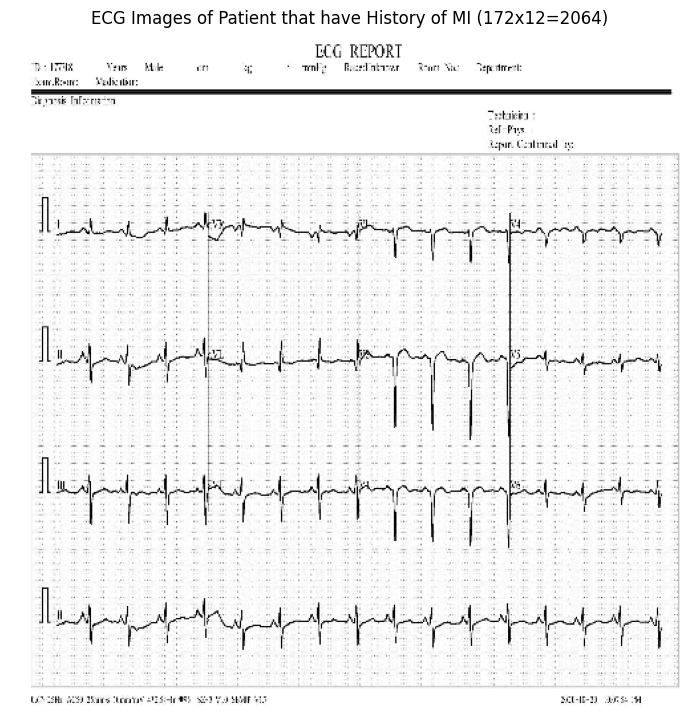

In [4]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray", vmin=0, vmax=255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
n_classes = len(class_names)

model = Sequential(
    [   
        # Input layer.
        Input(shape = (img_height, img_width, 1)),
        Rescaling(1./255),
        # Convolutions with subsequent pooling.
        Conv2D(filters = 16, kernel_size = (3, 3), activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        # Classification head.
        Flatten(),
        Dense(units = 128, activation = "relu"),
        Dense(units = n_classes, activation = "softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [6]:
callback = EarlyStopping(monitor="val_accuracy",
    mode = "max",
    patience=8,
    restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [7]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [callback]
)

Epoch 1/20


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 182s 3s/step - loss: 1.5136 - accuracy: 0.2727 - val_loss: 1.3824 - val_accuracy: 0.2935
Epoch 2/20
53/53 [==============================] - 187s 4s/step - loss: 1.2787 - accuracy: 0.4175 - val_loss: 1.1412 - val_accuracy: 0.5109
Epoch 3/20
53/53 [==============================] - 181s 3s/step - loss: 0.8980 - accuracy: 0.6615 - val_loss: 0.7352 - val_accuracy: 0.7283
Epoch 4/20
53/53 [==============================] - 180s 3s/step - loss: 0.4003 - accuracy: 0.8493 - val_loss: 0.3949 - val_accuracy: 0.8152
Epoch 5/20
53/53 [==============================] - 180s 3s/step - loss: 0.1659 - accuracy: 0.9545 - val_loss: 0.0535 - val_accuracy: 1.0000
Epoch 6/20
 1/53 [..............................] - ETA: 4:21 - loss: 0.0337 - accuracy: 1.0000

KeyboardInterrupt: 

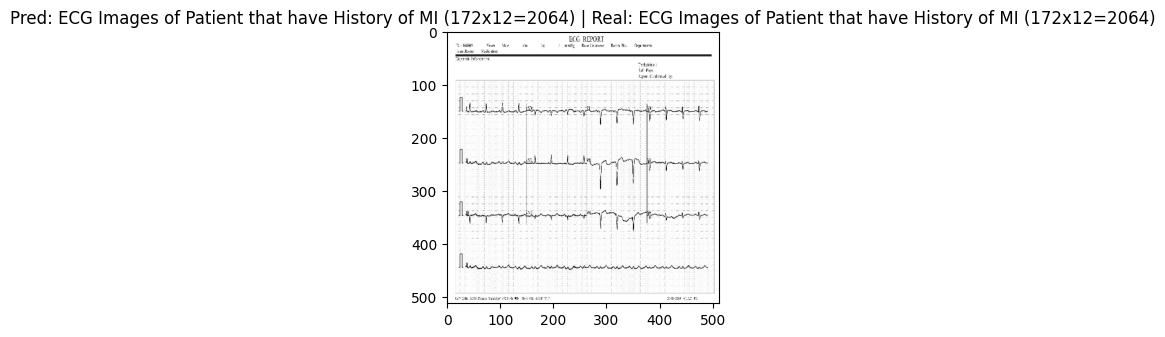

In [50]:
plt.figure(figsize=(25,12))
for images, labels in test_ds.take(4):
  classifications = model(images)
  # print(classifications)
  
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray", vmin=0, vmax=255)
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [80]:
import cv2


try:
    path="test (5).jpg"
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img, (512, 512))

except Exception as e:
    print(str(e))

In [82]:
classe = model.predict(np.reshape(img, (1,512,512,1)))
class_names[np.argmax(classe)]

1/1 [==============================] - 0s 114ms/step


'Normal Person ECG Images (284x12=3408)'

In [73]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\chris\AppData\Local\Temp\tmpl3li3llx\assets


INFO:tensorflow:Assets written to: C:\Users\chris\AppData\Local\Temp\tmpl3li3llx\assets
